In [58]:
import rasterio
from rasterio.windows import Window
from shapely.geometry.polygon import Polygon
from shapely import geometry
import tifffile as tiff
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path
import uuid

from dataset import (
    get_dataset, 
    save_map,
)
from vis import (
    plot_mask,
    plot_res
)

%load_ext autoreload
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


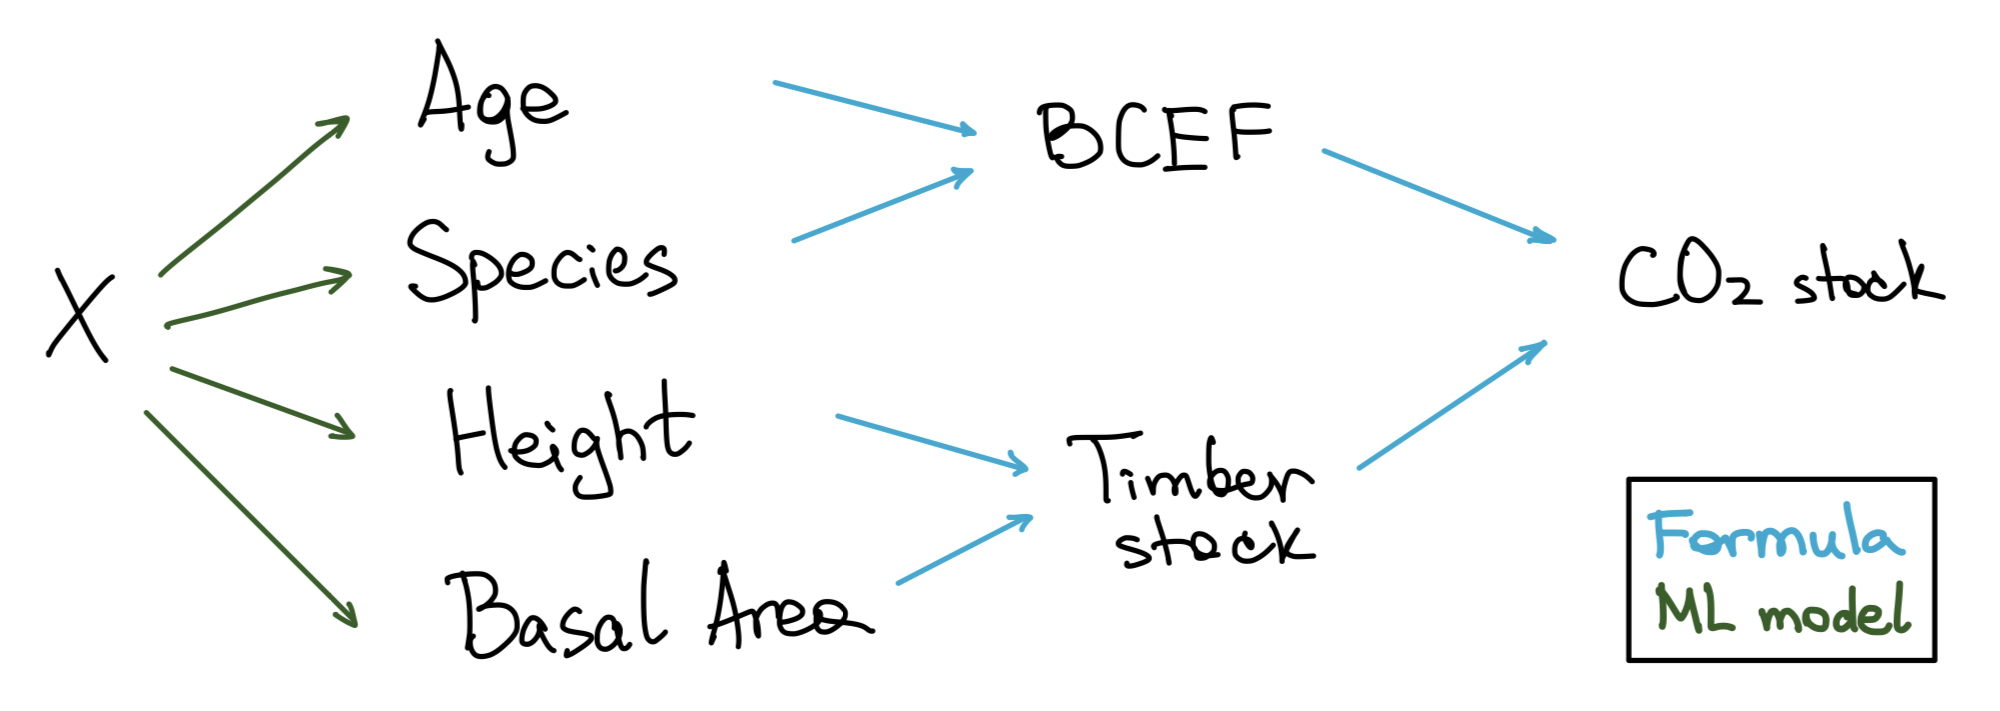**Input data**

1.   Sentinel-2 bands (L2A) (10 + 1 .tif images)
* bands: "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "SCL" 
* units: "DN"
* processing: "BILINEAR"
* resolution: 10 m
* sampleType: "INT16"
* one date from May to August
* year: 2018 - 2020

**Output**
* .tif file with carbon stock (m^3/ha) 


**Pipeline**

![Pipeline](img/pipeline.jpeg)

# Load data for inference

## Get tabular pixel dataset for given .tif file.  
We apply model only for pixels which are classified as vegetation (4 class) in Scene Classsification Layer (SCL).

`path_S2B` is the path, which contains .tif files, including `SCL.tif`

`window` is either an object of class `Window` from `rasterio.windows`, or `None`. If `None`, then full .tif file will be loaded.

`indices` is `True`/`False`, for adding vegetation indices (`ndvi`, `ndwi`, `msr670800`, `evi`, `savi`, `arvi`) 

![How to prepare data for inference](img/pixel-dataset.jpeg)

In [2]:
path_S2B = './data/tile_UTM38N/20180730/'

channels_list = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Region of Interest
y0, x0 = 7500, 2700
window = Window.from_slices((y0, y0 + 1952), (x0, x0 + 1200))

SCL Vegetation class (4):
Scene Classification Layer  map shape is: (1952, 1200)


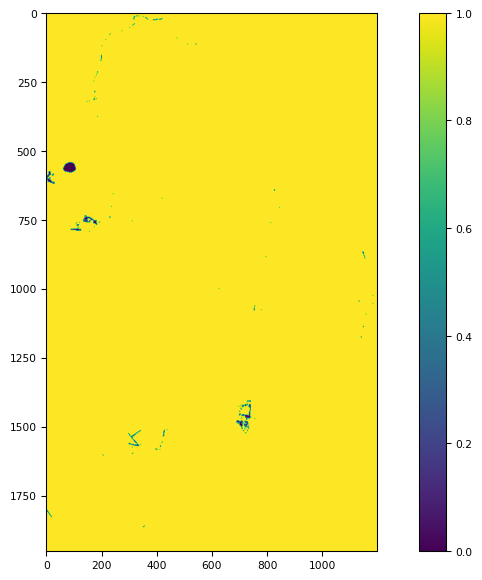

In [3]:
dataset = get_dataset(
    path_S2B, 
    channels_list=channels_list, 
    window=window, 
    visualise=True, 
    indices=True)

In [4]:
dataset.head(5)

,x,y,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,ndvi,ndwi,msr670800,evi,savi,arvi
0,0,0,206.0,342.0,159.0,635.0,2857.0,3691.0,3540.0,3999.0,1474.0,601.0,0.914031,0.412046,4.408638,2.865254,1.305085,0.923612
1,0,1,207.0,357.0,166.0,635.0,2857.0,3691.0,3772.0,3999.0,1474.0,601.0,0.915693,0.438048,4.459989,2.802736,1.307468,0.920371
2,0,2,204.0,363.0,161.0,618.0,2692.0,3465.0,3802.0,3754.0,1360.0,559.0,0.918748,0.473072,4.558224,2.810281,1.311831,0.917848
3,0,3,201.0,328.0,151.0,618.0,2692.0,3465.0,3392.0,3754.0,1360.0,559.0,0.914761,0.427609,4.431033,2.902561,1.306122,0.922768
4,0,4,197.0,309.0,153.0,587.0,2476.0,3098.0,3042.0,3386.0,1190.0,498.0,0.904225,0.437618,4.132058,2.908194,1.291061,0.913649


In [5]:
X = dataset.drop(labels=['x', 'y'], axis=1)

## Age prediction

In [6]:
from catboost import CatBoostRegressor

model_age = CatBoostRegressor()
model_age.load_model('weights/age-10bands-indices')

In [44]:
age = model_age.predict(X)
age = np.where(age > 0, age, 0)

## Species prediction

In [45]:
from catboost import CatBoostClassifier


#load model for type prediction 
model_species = CatBoostClassifier()
model_species.load_model('weights/species-10bands-indices-10000')

In [47]:
species = model_species.predict(X)

## Height prediction

In [41]:
model_height = CatBoostRegressor()
model_height.load_model('weights/height-10bands-indices')

In [48]:
height = model_height.predict(X)
height = np.where(height > 0, height, 0)

## Basal area prediction

In [18]:
#load modelf for area prediction 
model_area = CatBoostRegressor()
model_area.load_model('weights/basal-area-10bands-indices')

In [49]:
basal_area = model_area.predict(X)
basal_area = np.where(basal_area > 0, basal_area, 0)

## Get timber stock

In [52]:
volume = height * basal_area
volume = np.where((height > 0) & (basal_area > 0), volume, 0)

# Carbon Stock prediction

In [68]:
species_age = {
    1: [[0, 40], [40, 100], [100, 120], [120, 1000]],
    2: [[0, 20], [20, 40], [40, 50], [50, 1000]],
    3: [[0, 20], [20, 40], [40, 50], [50, 1000]],
    4: [[0, 20], [20, 30], [30, 40], [40, 1000]],
    5: [[0, 40], [40, 100], [100, 120], [120, 1000]],
              }

species_coeff = {
    1: [0.409, 0.426, 0.431, 0.436],
    2: [0.528, 0.534, 0.533, 0.528],
    3: [0.4, 0.4, 0.4, 0.4],
    4: [0.403, 0.426, 0.431, 0.444],
    5: [0.452, 0.454, 0.454, 0.449],
                }

C_content = {
    1: 0.5,
    2: 0.47,
    3: 0.48,
    4: 0.47, 
    5: 0.5
}

# mapping_col = {
#     'spruce': 1, # ель
#     'birch': 2, # береза
#     'mix': 3, # смешанный (не используем для подсчета запаса углерода)
#     'pine': 4, # сосна
#     'aspen': 5, # осина
# }

In [78]:
BCEF_species = {
    1: np.zeros(volume.shape),
    2: np.zeros(volume.shape), 
    3: np.zeros(volume.shape),
    4: np.zeros(volume.shape),
    5: np.zeros(volume.shape),
               }

tmp_shape = np.ones(volume.shape)

for sp in BCEF_species.keys():
    for age_ind in range(4):
        specimen_mask = np.where(species == sp, 1, 0) 
        age_condition = (species_age[sp][age_ind][0] * tmp_shape < age) & (age <= species_age[sp][age_ind][1] * tmp_shape)
        BCEF_species[sp] += np.where(age_condition, np.squeeze(specimen_mask * species_coeff[sp][age_ind]), 0)
    BCEF_species[sp] *= C_content[sp]

carbon_stock = volume * sum(BCEF_species.values())
carbon_stock = np.where(carbon_stock > 0, carbon_stock, 0)

In [79]:
save_map(
    carbon_stock, 
    dataset[['x', 'y']], 
    window=window, 
    no_data_value=-1, 
    clip=(0, None), 
    path_S2B=path_S2B, 
    out_name='pred-carbon-stock.tif'
        )

Saved to data/tile_UTM38N/20180730/pred-carbon-stock.tif
Out dtype: float32


res.shape is (1952, 1200)


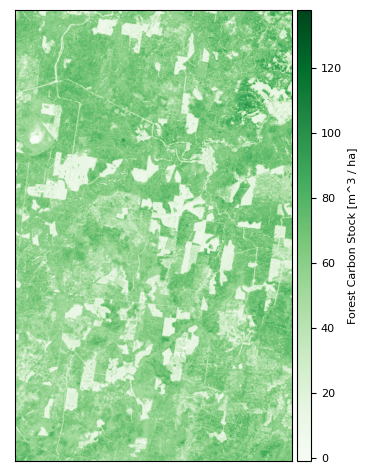

In [80]:
tif_age = Path(path_S2B) / 'pred-carbon-stock.tif'
plot_res(tif_age, cbar_label = 'Forest Carbon Stock [m^3 / ha]')